## Getting started
To run this notebook you need to install `pinocchio`, `meshcat` and `example_robot_data`. You can do it in your environment as follows


```bash
conda install pinocchio example-robot-data
pip install meshcat
```

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pinocchio as pin
import os
import time
import meshcat

from pinocchio.visualize import MeshcatVisualizer

import example_robot_data.robots_loader as robots


In [2]:
## this part of the code will load the panda robot model and display it
robot = robots.load('panda')

END_EFF_FRAME_ID = 17

viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)

try:
    viz.initViewer(open=True)
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install Python meshcat")
    print(err)
    sys.exit(0)
    
viz.loadViewerModel()

q0 = pin.neutral(robot.model)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


In [9]:
def translate(vector):
    transform = np.eye(4)
    transform[0,3] = vector[0]
    transform[1,3] = vector[1]
    transform[2,3] = vector[2]
    return transform

def rotateX(angle):
    transform = np.eye(4)
    transform[1,1] = np.cos(angle)
    transform[1,2] = -np.sin(angle)
    transform[2,1] = np.sin(angle)
    transform[2,2] = np.cos(angle)
    return transform

def rotateY(angle):
    transform = np.eye(4)
    transform[0,0] = np.round(np.cos(angle))
    transform[0,2] = np.round(np.sin(angle))
    transform[2,0] = np.round(-np.sin(angle))
    transform[2,2] = np.round(np.cos(angle))
    return transform

def rotateZ(angle):
    transform = np.eye(4)
    transform[0,0] = np.cos(angle)
    transform[0,1] = -np.sin(angle)
    transform[1,0] = np.sin(angle)
    transform[1,1] = np.cos(angle)
    return transform

def forward_kinematics(q):
    q = np.pad(q, (0, max(0, 8 - len(q))), 'constant')

    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    theta = [np.pi/2, -np.pi/2]

    # we define the lengths of the robot
    l0 = 0.333
    l1 = -0.316
    l2 = 0.0825
    l3 = -0.0825
    l4 = 0.384
    l5 = 0.088
    l6 = 0.107

    T_01 = translate([0,0,l0]) @ rotateZ(q[0])
    T_12 = rotateX(theta[1]) @ rotateZ(q[1])
    T_23 = translate([0,l1,0]) @ rotateX(theta[0]) @ rotateZ(q[2])
    T_34 = translate([l2,0,0]) @ rotateX(theta[0]) @ rotateZ(q[3])
    T_45 = translate([l3,l4,0]) @ rotateX(theta[1]) @ rotateZ(q[4])
    T_56 = rotateX(theta[0]) @ rotateZ(q[5])  
    T_67 = translate([l5,0,0]) @ rotateX(theta[0]) @ rotateZ(q[6])  
    T_7F = translate([0,0,l6]) 

    FK = T_01 @ T_12 @ T_23 @ T_34 @ T_45 @ T_56 @ T_67 @ T_7F

    return FK

forward_kinematics([0,0,0,0,0,0,0,0])  


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.80000000e-02],
       [ 0.00000000e+00, -1.00000000e+00, -1.22464680e-16,
        -8.93992163e-18],
       [ 0.00000000e+00,  1.22464680e-16, -1.00000000e+00,
         9.26000000e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [11]:
## use pinocchio to validate your FK function
## be careful as the pinocchio model has 9 DOFs (to account for the fingers)
## use the first 7 ones for the joint angles

## pose of the end-effector at the 0 configuration
q = np.array([0,0,0,0,0,0,0,0,0])
robot.forwardKinematics(q)
T_pin = robot.framePlacement(q, END_EFF_FRAME_ID)

viz.display(q)
print("Pinocchio FK at q0: \n", T_pin.homogeneous)

Pinocchio FK at q0: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  8.80000000e-02]
 [ 0.00000000e+00 -1.00000000e+00 -4.44089210e-16 -3.24185123e-17]
 [ 0.00000000e+00  4.44089210e-16 -1.00000000e+00  9.26000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [59]:
## pose of the end-effector at a random configuration
q[0:7] = np.random.rand(7)
robot.forwardKinematics(q)
T_pin = robot.framePlacement(q, END_EFF_FRAME_ID)

viz.display(q)
print(f"Pinocchio FK at a random pose q = {q[0:7]}: \n\n", T_pin.homogeneous)

Pinocchio FK at a random pose q = [0.93954381 0.61313663 0.38107843 0.66406933 0.49543319 0.18549066
 0.32070241]: 

 [[ 0.19263212  0.960271   -0.20192193  0.12819604]
 [ 0.93840894 -0.12012257  0.32397412  0.19761515]
 [ 0.28684757 -0.25189316 -0.92426636  0.84626902]
 [ 0.          0.          0.          1.        ]]


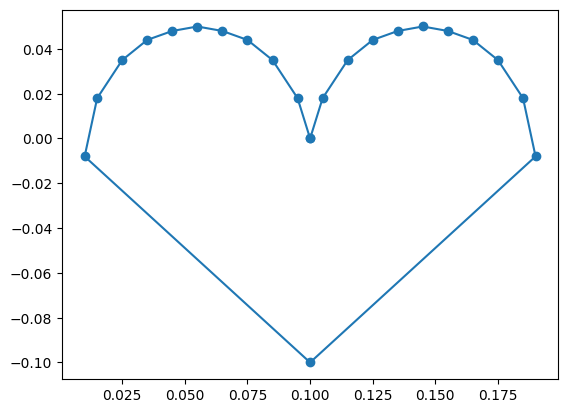

In [7]:
import matplotlib.pyplot as plt
import numpy as np

## we load the file robot_trajectory.npy - it contains a list of 23 joint configurations
robot_trajectory = np.load('robot_trajectory.npy')

x_value = []
y_value = []

for i in range(23):
    value = robot_trajectory[i]
    position = forward_kinematics(value)
    x_value.append(position[0,3])
    y_value.append(position[1,3])

plt.plot(x_value, y_value, '-o')
plt.show()